In [1]:
import os
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Flatten, Dropout
from keras.models import Sequential
from tensorflow.keras.regularizers import l1_l2, l1, l2
from keras import regularizers
from tensorflow.keras.layers import LeakyReLU, BatchNormalization,GlobalAveragePooling2D,Conv2D,Reshape
import sys
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau, Callback
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.losses import MeanSquaredLogarithmicError
from PIL import Image
from tensorflow.keras.optimizers import SGD
from sklearn.utils import resample
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score
import tensorflow as tf
from keras.metrics import Precision, Recall
sys.modules['Image'] = Image 

In [2]:
target_size = 64,64
Batch_size = 32
learning_rate = 0.003
epochs = 170
SEED = 12

In [3]:
datagen = ImageDataGenerator()

datagen = ImageDataGenerator(
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    'C:/Users/TomHu/OneDrive/Desktop/Final Year project/Train',
    target_size=target_size,
    batch_size=Batch_size,
    class_mode='categorical',
    subset='training',
    seed=SEED,
    shuffle=True
)

validation_generator = datagen.flow_from_directory(
    'C:/Users/TomHu/OneDrive/Desktop/Final Year project/Train', # same directory as training data
    target_size=target_size,
    batch_size=Batch_size,
    class_mode='categorical',
    subset='validation',
    seed=SEED
) # set as validation data


test_generator = datagen.flow_from_directory(
    'C:/Users/TomHu/OneDrive/Desktop/Final Year project/Test',
    target_size=target_size,
    batch_size=Batch_size,
    class_mode='categorical',
    shuffle =False
)



Found 1013081 images belonging to 14 classes.
Found 253264 images belonging to 14 classes.
Found 111308 images belonging to 14 classes.


In [4]:
from keras import backend as K

def f1_macro(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [5]:
# Load the pre-trained VGG-16 model without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))


# Create a new model and add the pre-trained VGG-16 as the base
model = Sequential()
model.add(base_model)

# Add new layers on top of the pre-trained VGG-16
model.add(Flatten())
model.add(Dense(256, activation='relu')) # Increased to 512 units
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu')) 
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu')) # Increased to 128 units
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu')) # Increased to 512 units
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu')) 
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu')) # Increased to 128 units
model.add(Dropout(0.2))
model.add(Dense(14, activation='sigmoid'))
# Loop through all layers in the model
model.layers[0].trainable = False
for layer in model.layers:
    print(layer.name, layer.trainable)

vgg16 False
flatten True
dense True
dropout True
dense_1 True
dropout_1 True
dense_2 True
dropout_2 True
dense_3 True
dropout_3 True
dense_4 True
dropout_4 True
dense_5 True
dropout_5 True
dense_6 True


In [6]:
# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_delta=0.000001)

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
early_stop = EarlyStopping(monitor='val_loss', patience=10)


model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy", Precision(), Recall(), f1_macro])

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              5

In [7]:
class_dict = {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 0.04, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1}
class_weights = {'Abuse': 1, 'Arrest': 1, 'Arson': 1, 'Assault': 1, 'Burglary': 1, 'Explosion': 1, 'Fighting': 1, 'NormalVideos': 0.075,
                 'RoadAccidents': 1, 'Robbery': 1, 'Shooting': 1, 'Shoplifting': 1, 'Stealing': 1, 'Vandalism': 1}
# Get the number of samples in each class
class_counts = train_generator.classes
class_labels = list(train_generator.class_indices.keys())
class_sample_counts = np.bincount(class_counts)
class_sample_dict = dict(zip(class_labels, class_sample_counts))
count = 0
# Calculate the weighted count of samples in each class
weighted_class_sample_dict = {} 
for count, (class_label, sample_count) in enumerate(class_sample_dict.items()):
    class_label_str = class_labels[count]
    weight = class_weights[class_label_str]
    weighted_sample_count = weight * sample_count
    weighted_class_sample_dict[class_label_str] = weighted_sample_count
    count=+1


# Print out the number of samples in each class with applied class weights
print("Class Sample Counts (Weighted):")
for class_label, sample_count in weighted_class_sample_dict.items():
    print("Class {}: {} samples".format(class_label, sample_count))
    

Class Sample Counts (Weighted):
Class Abuse: 15261 samples
Class Arrest: 21118 samples
Class Arson: 19537 samples
Class Assault: 8288 samples
Class Burglary: 31604 samples
Class Explosion: 15003 samples
Class Fighting: 19748 samples
Class NormalVideos: 56866.125 samples
Class RoadAccidents: 18789 samples
Class Robbery: 33195 samples
Class Shooting: 5712 samples
Class Shoplifting: 19868 samples
Class Stealing: 35842 samples
Class Vandalism: 10901 samples


In [8]:
class_labels = list(train_generator.class_indices.keys())
print("Class Labels:", class_labels)

Class Labels: ['Abuse', 'Arrest', 'Arson', 'Assault', 'Burglary', 'Explosion', 'Fighting', 'NormalVideos', 'RoadAccidents', 'Robbery', 'Shooting', 'Shoplifting', 'Stealing', 'Vandalism']


In [9]:
from tensorflow.keras.callbacks import Callback

class UnfreezeLayersCallback(Callback):
    def __init__(self, patience=5):
        super(UnfreezeLayersCallback, self).__init__()
        self.patience = patience
        self.wait = 0
        self.callcount = 0
        self.best_val_loss = None  # Add the best_val_loss attribute

    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        val_loss = logs.get('val_loss')
        if val_loss is None:
            return

        if self.wait == self.patience and self.callcount == 0:
            layers = self.model.layers
            for layer in layers:
                layer.trainable = True
            print("Freezing all layers")
            self.callcount += 1
        else:
            if epoch == 0:
                self.best_val_loss = val_loss
            elif val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.wait = 0
            else:
                self.wait += 1

In [10]:
for layer in model.layers:
    print(layer.name, layer.trainable)


vgg16 False
flatten True
dense True
dropout True
dense_1 True
dropout_1 True
dense_2 True
dropout_2 True
dense_3 True
dropout_3 True
dense_4 True
dropout_4 True
dense_5 True
dropout_5 True
dense_6 True


In [11]:
history = model.fit(
        train_generator,
        steps_per_epoch= (train_generator.n/Batch_size)/500,
        epochs=400,
        validation_data=validation_generator,
        validation_steps= (validation_generator.n/Batch_size)/500,
        callbacks=[early_stop, reduce_lr, UnfreezeLayersCallback()],
        batch_size=Batch_size,
        class_weight=class_dict
)

Epoch 1/400
63/63 [==============================] - 22s 271ms/step - loss: 0.7901 - accuracy: 0.0981 - precision: 0.1286 - recall: 0.8340 - f1_macro: 0.2253 - val_loss: 2.5628 - val_accuracy: 0.0273 - val_precision: 0.1183 - val_recall: 0.9277 - val_f1_macro: 0.2099
Epoch 2/400
63/63 [==============================] - 19s 306ms/step - loss: 0.7035 - accuracy: 0.1914 - precision: 0.1584 - recall: 0.8813 - f1_macro: 0.2701 - val_loss: 2.3609 - val_accuracy: 0.1426 - val_precision: 0.2120 - val_recall: 0.8438 - val_f1_macro: 0.3388
Epoch 3/400
63/63 [==============================] - 19s 300ms/step - loss: 0.7329 - accuracy: 0.0483 - precision: 0.1669 - recall: 0.8740 - f1_macro: 0.2852 - val_loss: 2.4437 - val_accuracy: 0.0273 - val_precision: 0.1696 - val_recall: 0.8516 - val_f1_macro: 0.2829
Epoch 4/400
63/63 [==============================] - 19s 300ms/step - loss: 0.7237 - accuracy: 0.0352 - precision: 0.1585 - recall: 0.8740 - f1_macro: 0.2713 - val_loss: 2.4061 - val_accuracy: 0.0

for layer in model.layers:
    print(layer.name, layer.trainable)

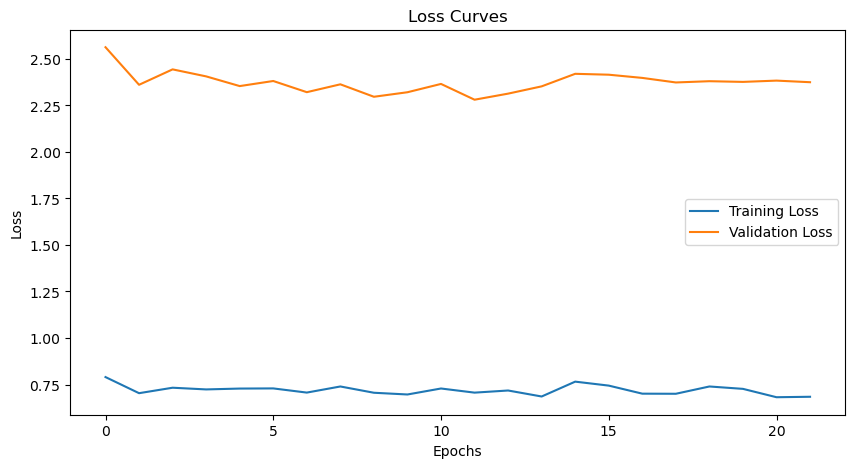

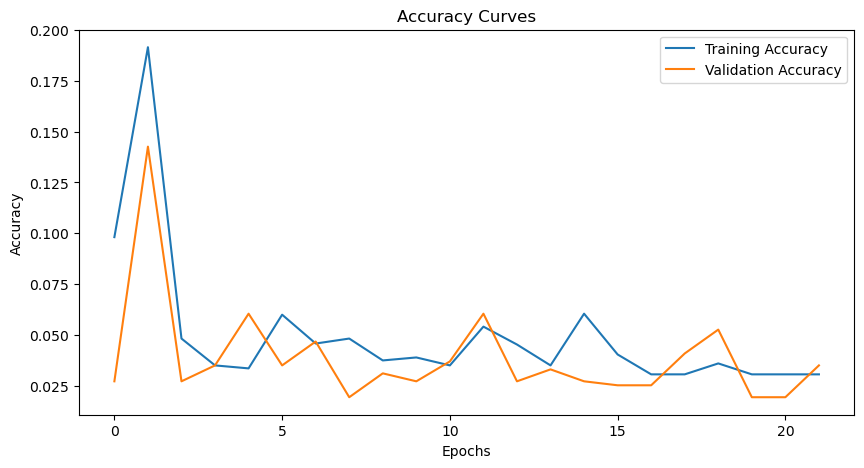

In [12]:
# Extract loss and accuracy values from history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy curves
plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [13]:
pred = model.evaluate(test_generator, batch_size=Batch_size)

3479/3479 [==============================] - 779s 224ms/step - loss: 2.5229 - accuracy: 0.0075 - precision: 0.1220 - recall: 0.7318 - f1_macro: 0.2090


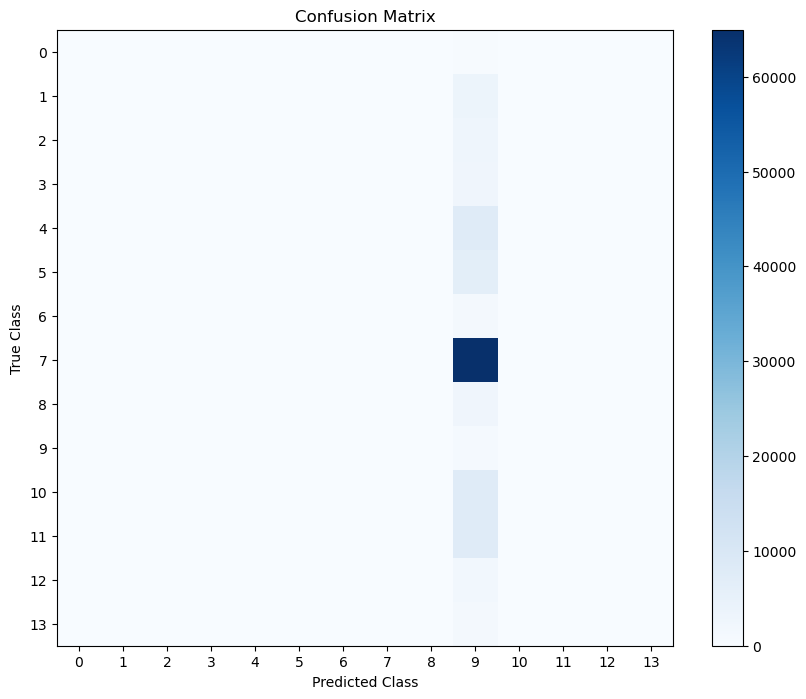

In [14]:
# Make predictions on test data
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predicted probabilities to class labels

# Get actual labels of test data
y_true = test_generator.classes

# Create confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(confusion_mtx, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(14))
plt.yticks(np.arange(14))
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()